In [1]:
import numpy as np
import pandas as pd

from collections import defaultdict
from natsort import natsorted

import matplotlib.pyplot as plt
import seaborn as sns

## Open Dataset

In [2]:
df = pd.read_excel("data stok beras.xlsx")
df['Tanggal'] =  pd.to_datetime(df['Tanggal'])
df = df.set_index('Tanggal')
df.head()

/home/darma/miniconda3/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


,kuantitas
Tanggal,
2019-01-01,100450
2019-02-01,92951
2019-03-01,101750
2019-04-01,93501
2019-05-01,19447


## Class Fitness(Fuzzy Time Series Chen)
untuk mencari nilai fitness

In [3]:
class Fitness:
    def __init__(self,X_test:pd.DataFrame,universe_discource:tuple):
        """ 
            self.X = numpy array ndim:1
            self.X_test = DataFrame 
            uni_disc = tuple
        """
        self.X_test = X_test
        self.uni_disc  = universe_discource
    
    # 1 -----
    def sub_himpunan(self,X:np.ndarray):
        """
        X:ndarray 1 ndim
        """
        uni_disc =  self.uni_disc
        p1 = np.insert(X,0,uni_disc[0])
        p1 = np.append(p1,uni_disc[1])
        sub_himpunan = pd.DataFrame({
            'Batas Bawah': p1[:-1],
            'Batas Atas': p1[1:],
            'u' : [i for i in range(1,len(X)+2)]
        })
        sub_himpunan["A"] = np.array([f"A{i}" for i in range(1,len(X)+2)])
        return sub_himpunan
    def fuzzyfikasi(self,X:np.ndarray):
        sub_himpunan = self.sub_himpunan(X).values
        def cek_posisi(nilai, data):
            for i, batas in enumerate(data):
                if nilai >= batas[0] and nilai <= batas[1]:
                    return f"A{i+1}"
            return "Nilai tidak berada dalam rentang yang diberikan"
        hasil_a = []
        X_test = self.X_test.copy()
        # data = sub_himpunan.values
        hasil_a = []
        for nilai in X_test['kuantitas'].values:
            # Memeriksa posisi nilai dalam data
            hasil = cek_posisi(nilai, sub_himpunan)
            hasil_a.append(hasil)
            # Menampilkan hasil
        X_test["A"] = hasil_a
        return X_test
    # -----
    
    def FLR(self,fuzzyfikasi:pd.DataFrame):
        X_test = fuzzyfikasi
        tanggal = X_test.index
        FLR = X_test['A'].values
        table_FLR = pd.DataFrame({
            'T(current)': tanggal[:-1],
            'T(t+1)': tanggal[1:],
            'F(current)': FLR[:-1],
            'F(t+1)': FLR[1:],
        })
        return table_FLR
    
    def FLRG(self,FLR:pd.DataFrame):
        # Membuat FLRG
        table_FLR = FLR
        flrg_dict = defaultdict(set)

        for index, row in table_FLR.iterrows():
            current = row['F(current)']
            next_stage = row['F(t+1)']

            if current not in flrg_dict:
                flrg_dict[current] = set()

            if next_stage:
                flrg_dict[current].add(next_stage)

        # Mengurutkan FLRG berdasarkan nilai F(current) menggunakan natsorted
        sorted_flrg = natsorted(flrg_dict.items())

        # Membuat DataFrame baru dari FLRG yang sudah diurutkan
        flrg = pd.DataFrame(sorted_flrg, columns=['F(current)', 'F(t+1)'])
        flrg['F(t+1)'] = flrg['F(t+1)'].apply(lambda x: ','.join(natsorted(x)) if x else '')

        # Menampilkan DataFrame hasilnya
        return flrg
    def nilai_tengah(self,X:np.ndarray):
        sub_himpunan = self.sub_himpunan(X)
        def n(i):
            x = sub_himpunan.loc[sub_himpunan['A'] == i]
            x_bawah = x['Batas Bawah'].values[0]
            x_atas = x['Batas Atas'].values[0]
            return (x_bawah+x_atas)/2
        sub_himpunan["Nilai Tengah"] = sub_himpunan["A"].apply(n)
        return sub_himpunan
    def defuzzifikasi(self,X:np.ndarray,FLR:pd.DataFrame):
        sub_himpunan = self.nilai_tengah(X)
        defuzzifikasi = []
        flrg = self.FLRG(FLR)
        f =  []
        hasil = []
        for i in sub_himpunan["A"].values :
            if i in flrg['F(current)'].values :
                defuz = flrg.loc[flrg['F(current)'] == i]['F(t+1)'].values[0].split(",")
                nilai_tengah = sub_himpunan.loc[sub_himpunan["A"].isin(defuz)]['Nilai Tengah'].values
            else:
                defuz = [i]
                nilai_tengah =  sub_himpunan.loc[sub_himpunan["A"] == i]["Nilai Tengah"].values
            defuzzifikasi.append(defuz)
            f.append(i)
            hasil.append(np.mean(nilai_tengah))
        return pd.DataFrame({"f(t-1)":f,"defuzzifikasi":defuzzifikasi,"hasil":hasil})
    def forecast(self,X:np.ndarray):
        
        fuzz = self.fuzzyfikasi(X)
        table_FLR = self.FLR(fuzz)
        
        j = 1
        z_ = {}
        X_test = self.X_test
        
        defuzzifikasi =  self.defuzzifikasi(X,table_FLR)
        for i in X_test.index:
            if i in table_FLR["T(current)"].values:
                z =  table_FLR.loc[(table_FLR["T(current)"] == i)]["F(current)"].values[0]
            else:
                z =  table_FLR.loc[(table_FLR["T(t+1)"] == i)]["F(current)"].values[0]
                continue
            j+=1
            z = defuzzifikasi.loc[defuzzifikasi['f(t-1)']==z]["hasil"].values[0]
            z_[j] = z
        
        hasil_peramalan = []
        for i in range(1,len(X_test)+1):
            aktual = X_test.iloc[i-1]["kuantitas"]
            X = X_test.index[i-1].date().strftime("%b-%Y")

            if i == 1:
                p_ = [X,aktual,None,None,None]
            else:
                pred =  z_[i]
                err = (aktual-pred)**2
                absolute_error =  abs(aktual-pred)/aktual
                p_ = [X,aktual,pred,err,absolute_error]
            hasil_peramalan.append(p_)

        hasil_peramalan = pd.DataFrame(hasil_peramalan,columns=[["tanggal","kuantitas","prediksi","error","nilai_abs_err"]])
        return hasil_peramalan

    
        

## Inisiasi Parameter

In [18]:
X = df['kuantitas'].values

X_test = df.loc[(df.index >= '2022-03-01')
                     & (df.index <= '2023-10-01')]

n_particles = 4
n_dimensions = 10



bobot_inersia = 0.6
c1 = 1.5
c2 = 0.5


# Partikel Awal
X_partikel = pd.DataFrame({
    'P1': [24458, 36789, 45216, 55671, 63779, 72890, 84312, 95624, 102543, 118345],
    'P2': [22345, 28760, 41567, 54321, 67890, 73456, 81234, 88765, 95432, 112345],
    'P3': [26789, 31234, 50432, 62345, 74567, 84567, 92345, 101234, 107890, 115678],
    'P4': [25789, 33234, 45678, 58432, 61789, 76543, 87654, 95432, 104321, 112345]
})
kecepatan_ = np.zeros(X_partikel.T.shape)

X_max_partikel =  np.max(X_partikel.values)
X_min_partikel =  np.min(X_partikel.values)
X_partikel_t =  X_partikel.T

D1 =  3345
D2 = 1655

universe_discourse = X_min_partikel-D1,X_max_partikel+D2

Xmin,Xmax = universe_discourse
k = 0.6
vmax = k*(Xmax-Xmin)/2
vmin = -vmax

print("Nilai Himpunan Semesta: ",universe_discourse)
print("Partikel Awal: ")
print(X_partikel.T)

Nilai Himpunan Semesta:  (19000, 120000)
Partikel Awal: 
        0      1      2      3      4      5      6       7       8       9
P1  24458  36789  45216  55671  63779  72890  84312   95624  102543  118345
P2  22345  28760  41567  54321  67890  73456  81234   88765   95432  112345
P3  26789  31234  50432  62345  74567  84567  92345  101234  107890  115678
P4  25789  33234  45678  58432  61789  76543  87654   95432  104321  112345


## Inisiasi Model Fuzzy Time Series Chen

In [19]:
model =  Fitness(X_test,universe_discourse)

In [20]:
model.forecast(X=X_partikel["P1"].values)

,tanggal,kuantitas,prediksi,error,nilai_abs_err
0,Mar-2022,52128,NaN,NaN,NaN
1,Apr-2022,48046,80443.750,1.049614e+09,0.674307
2,May-2022,116508,80443.750,1.300630e+09,0.309543
3,Jun-2022,19447,21729.000,5.207524e+06,0.117345
4,Jul-2022,70853,57537.375,1.773059e+08,0.187933
5,Aug-2022,100450,88842.250,1.347399e+08,0.115557
6,Sep-2022,29423,52663.750,5.401325e+08,0.789884
7,Oct-2022,24416,21729.000,7.219969e+06,0.110051
8,Nov-2022,97073,57537.375,1.563066e+09,0.407277
9,Dec-2022,93501,52663.750,1.667681e+09,0.436757


## PSO

In [21]:
def get_fitness(X_partikel):
    fitness = {}
    for i in X_partikel.columns:
        hasil = model.forecast(X_partikel[i].values)
        hasil = hasil.dropna()
        mape_ = np.sum(hasil['nilai_abs_err'].values)/20
        fitness[i] =  mape_
        # print(f"{i} = {X_partikel[i].values} => {mape_}")
    key_GBEST = min(fitness,key=fitness.get)
    GBEST = X_partikel[key_GBEST].values
    print(f"GBEST[{key_GBEST}] => {GBEST} => {fitness[key_GBEST]}")
    return GBEST,fitness[key_GBEST]
def update_v(pbest,gbest):
    bobot_inersia = 0.6 
    r1 = 0.3
    c1 = 1.5
    pbestT = pbest
    c2 = 0.5
    r2 = 0.6
    gbestT = gbest
    v = bobot_inersia * 0 + c1 * r1 * (pbestT - pbestT) + c2 * r2 * (gbestT - pbestT)
    return v
def update_kecepatan(kecepatan,GBEST,pbest):
    for i in range(len(kecepatan)):
        for j in range(len(kecepatan[i])):
            v = update_v(pbest.values[i][j],GBEST[j])
            kecepatan[i][j] = v
    return kecepatan
    
def update_partikel(X_partikel,kecepatan):
    pbest_new = X_partikel_t.values + kecepatan
    pbest_new = pd.DataFrame(pbest_new.T,columns=X_partikel.columns)
    return pbest_new

In [22]:
def pso(iterations,X_partikel):
    pbest = X_partikel
    kecepatan_arr = np.zeros(pbest.T.shape)
    var = {}
    for it in range(iterations):
        print(f"iterasi => {it+1}")
        GBEST,fitness = get_fitness(pbest)
        kecepatan =  update_kecepatan(kecepatan_arr,GBEST,pbest.T)
        pbest = update_partikel(pbest,kecepatan)
        var[fitness] = GBEST
        print()
    return var
MAX_ITERATIONS = 20
result = pso(MAX_ITERATIONS,X_partikel)


iterasi => 1
GBEST[P3] => [ 26789  31234  50432  62345  74567  84567  92345 101234 107890 115678] => 0.34050050746987026

iterasi => 2
GBEST[P1] => [ 25157.3  35122.5  46780.8  57673.2  67015.4  76393.1  86721.9  97307.
 104147.1 117544.9] => 0.2466331036517348

iterasi => 3
GBEST[P3] => [ 26299.49  32400.55  49336.64  60943.46  72301.52  82114.83  90658.07
 100055.9  106767.13 116238.07] => 0.3013537986227802

iterasi => 4
GBEST[P2] => [ 23398.228  29346.338  43668.005  56222.688  69472.449  76089.307
  83867.307  91720.153  98384.546 113134.921] => 0.25373129711418996

iterasi => 5
GBEST[P3] => [ 25771.7684  30667.7014  48402.8015  60508.3064  73038.6347  82023.6921
  89801.6921  98379.8459 105038.3638 114915.0763] => 0.21319187068353954

iterasi => 6
GBEST[P2] => [ 23373.03052  29332.31042  43617.74045  56177.19192  69434.59041
  76026.30763  83804.30763  91649.45377  98313.90914 113116.02289] => 0.253524267457628

iterasi => 7
GBEST[P3] => [ 25764.209156  30663.493126  48387.722135

In [24]:
ex =  list(result.values())[0]
GBEST_I = pd.DataFrame(list(result.values()),columns=[f"X{i}" for i in range(1,len(ex)+1)])
GBEST_I

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,26789.000000,31234.000000,50432.000000,62345.000000,74567.000000,84567.000000,92345.000000,101234.000000,107890.000000,115678.000000
1,25157.300000,35122.500000,46780.800000,57673.200000,67015.400000,76393.100000,86721.900000,97307.000000,104147.100000,117544.900000
2,26299.490000,32400.550000,49336.640000,60943.460000,72301.520000,82114.830000,90658.070000,100055.900000,106767.130000,116238.070000
3,23398.228000,29346.338000,43668.005000,56222.688000,69472.449000,76089.307000,83867.307000,91720.153000,98384.546000,113134.921000
4,25771.768400,30667.701400,48402.801500,60508.306400,73038.634700,82023.692100,89801.692100,98379.845900,105038.363800,114915.076300
5,23373.030520,29332.310420,43617.740450,56177.191920,69434.590410,76026.307630,83804.307630,91649.453770,98313.909140,113116.022890
6,25764.209156,30663.493126,48387.722135,60494.657576,73027.277123,82004.792289,89782.792289,98358.636131,105017.172742,114909.406867
7,23370.762747,29331.047938,43613.216641,56173.097273,69431.183137,76020.637687,83798.637687,91643.090839,98307.551823,113114.322060
8,25763.528824,30663.114381,48386.364992,60493.429182,73026.254941,82003.091306,89781.091306,98356.727252,105015.265547,114908.896618
9,23370.558647,29330.934314,43612.809498,56172.728755,69430.876482,76020.127392,83798.127392,91642.518176,98306.979664,113114.168985


In [25]:
fitness_ = pd.DataFrame({'id_GBEST':GBEST_I.index,'fitness':[i for i in result.keys()]})


## GBEST dengan nilai FITNESS Terbaik

In [26]:
ID_GBEST_RESULT = fitness_[fitness_['fitness'] == np.min(fitness_['fitness'])]
ID_GBEST_RESULT

,id_GBEST,fitness
4,4,0.213192


In [27]:
GBEST_RESULT = GBEST_I.iloc[ID_GBEST_RESULT['id_GBEST'].values[0]].values
GBEST_RESULT

array([ 25771.7684,  30667.7014,  48402.8015,  60508.3064,  73038.6347,
        82023.6921,  89801.6921,  98379.8459, 105038.3638, 114915.0763])

In [28]:
hasil_peramalan =  model.forecast(GBEST_RESULT)

In [29]:
hasil_peramalan

,tanggal,kuantitas,prediksi,error,nilai_abs_err
0,Mar-2022,52128,NaN,NaN,NaN
1,Apr-2022,48046,39535.251450,7.243284e+07,0.177138
2,May-2022,116508,117457.538150,9.016227e+05,0.008150
3,Jun-2022,19447,22385.884200,8.637040e+06,0.151123
4,Jul-2022,70853,55696.343800,2.297242e+08,0.213917
5,Aug-2022,100450,89620.134125,1.172860e+08,0.107813
6,Sep-2022,29423,25302.809550,1.697597e+07,0.140033
7,Oct-2022,24416,22385.884200,4.121370e+06,0.083147
8,Nov-2022,97073,55696.343800,1.712028e+09,0.426243
9,Dec-2022,93501,87524.448133,3.571917e+07,0.063920


## Mape

In [30]:
h =  hasil_peramalan.dropna()
mape =  np.sum(h['nilai_abs_err'].values)/20
mape

0.21319187068353954

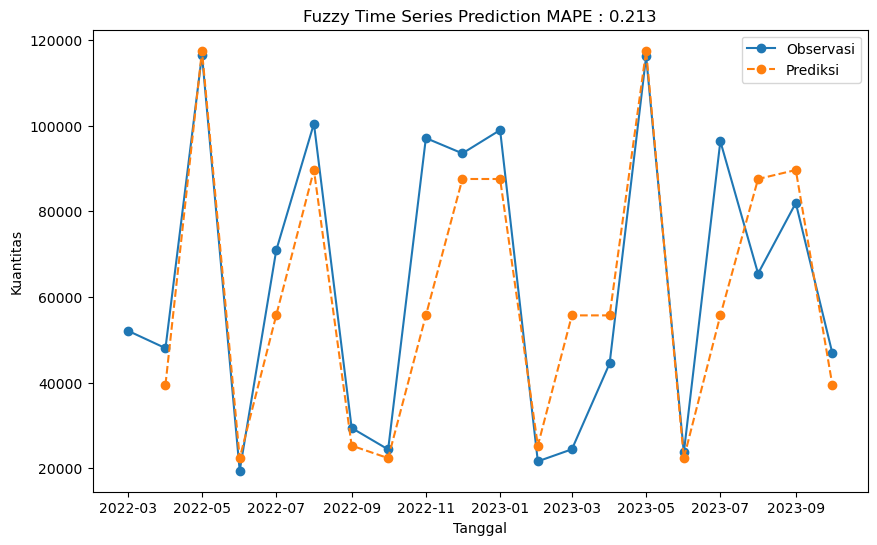

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, hasil_peramalan['kuantitas'].values, label='Observasi', marker='o')
plt.plot(X_test.index, hasil_peramalan['prediksi'].values, label='Prediksi', linestyle='--', marker='o')  # Dimulai dari indeks ke-2 untuk mengatasi nilai prediksi yang kurang
plt.title(f'Fuzzy Time Series Prediction MAPE : {mape.round(3)}')
plt.xlabel('Tanggal')
plt.ylabel('Kuantitas')
plt.legend()
plt.show()